<a href="https://colab.research.google.com/github/shuseiyokoi/data-science-portfolio/blob/main/CPPI_simulation/CPPI_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction
Constant Proportion Portfolio Insurance (CPPI) is a popular investment strategy used to manage portfolio risk while seeking higher returns. The method allocates funds between risky and risk-free assets based on a defined "cushion," which represents the excess of portfolio value over a predefined floor. This project demonstrates a CPPI strategy simulation using real-world financial data retrieved from Yahoo Finance.

more about CPPI (Notion):[Constant Proportion Portfolio Insurance (CPPI) Simulation with Real Data ](https://shuseiyokoi.notion.site/Constant-Proportion-Portfolio-Insurance-CPPI-Simulation-with-Real-Data-46293964a93e4380b7c9014418d0250d?pvs=4)



------------
### Setup
To start, we install and import the necessary Python libraries for data manipulation, visualization, and interactive widgets.



In [5]:
# !pip install numpy matplotlib ipywidgets requests datetime pandas matplotlib

import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import requests
import datetime
import calendar
import pandas as pd
from pandas import json_normalize
import matplotlib.dates as mdates
import time


### Fetching Real-World Data
In this step, we use the Yahoo Finance API to retrieve historical stock data. The stock symbol can be adjusted as needed (e.g., 'AAPL' for Apple Inc.), and the data is collected from the start of UNIX time to the current date in daily intervals.

In [9]:
# Change symbol
symbol = 'AAPL'
# Dates should be in UNIX form
start_date = 1262304000
today_utc = datetime.datetime.utcnow().date()
# Create a datetime object for midnight of today's date in UTC
midnight_utc = datetime.datetime.combine(today_utc, datetime.time(0, 0))
# Convert to a time tuple in UTC
end_date = calendar.timegm(midnight_utc.utctimetuple())

interval = '1d'

url = f'https://query2.finance.yahoo.com/v8/finance/chart/{symbol}?period1={start_date}&period2={end_date}&interval={interval}'


# Mimic Header
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/114.0.0.0 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8",
    "Accept-Encoding": "gzip, deflate, br",
    "Accept-Language": "en-US,en;q=0.9"
}
esp_json = requests.get(url, headers=headers)

### CPPI Simulation Function
This function implements the CPPI strategy. It calculates and visualizes portfolio allocation over time, balancing between safe and risky assets based on user-defined parameters such as initial wealth, floor value, and risk multiplier.

In [10]:
def cppi_simulation_plot (initial_wealth = 100000, floor = 80000, multiplier = 3, start_date = 0 ,risk_free_rate = 0.02, balance_in = 30):

    dictr = esp_json.json()
    recs = dictr['chart']['result'][0]['indicators']['adjclose'][0]['adjclose']
    timestamp = dictr['chart']['result'][0]['timestamp'][start_date:]
    timestamp.pop(0)
    timestamp = [datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d') for ts in timestamp]
    timestamp = pd.to_datetime(timestamp)
    recs = pd.DataFrame(recs)
    recs = recs.pct_change().dropna().to_numpy()[start_date:]
    daily_risk_return = recs
    num_periods = len(daily_risk_return)

    # Create vectors of portfolio, safe asset, and risky asset values and give initial points
    portfolio_value = np.zeros(num_periods)
    portfolio_value[0] = initial_wealth

    safe_asset_value = np.zeros(num_periods)
    safe_asset_value[0] = initial_wealth - (initial_wealth - floor) * multiplier

    risky_asset_value = np.zeros(num_periods)
    risky_asset_value[0] = (initial_wealth - floor) * multiplier


    for t in range(0, num_periods):

        # Allocate to risky asset based on the cushion and multiplier
        risky_allocation = risky_asset_value[t-1]
        safe_allocation = safe_asset_value[t-1]

        # Calculate returns
        risky_asset_return = risky_allocation * (1 + daily_risk_return[t])
        safe_asset_return = safe_allocation * (1 + risk_free_rate / num_periods)

        # Update portfolio value
        portfolio_value[t] = risky_asset_return.item() + safe_asset_return.item() if isinstance(risky_asset_return, np.ndarray) else risky_asset_return + safe_asset_return
        risky_asset_value[t] = risky_asset_return.item() if isinstance(risky_asset_return, np.ndarray) else risky_asset_return
        safe_asset_value[t] = safe_asset_return.item() if isinstance(safe_asset_return, np.ndarray) else safe_asset_return


        # Run below code by given frequency days
        if t % balance_in == 0:

            # Calculate current cushion
            cushion = max(portfolio_value[t-1] - floor, 0)

            # Allocate to risky asset based on the cushion and multiplier
            risky_allocation = multiplier * cushion
            safe_allocation = portfolio_value[t-1] - risky_allocation

            # Calculate returns
            risky_asset_return = risky_allocation * (1 + daily_risk_return[t])
            safe_asset_return = safe_allocation * (1 + risk_free_rate / num_periods)

            # Update portfolio value
            portfolio_value[t] = risky_asset_return.item() + safe_asset_return.item() if isinstance(risky_asset_return, np.ndarray) else risky_asset_return + safe_asset_return
            risky_asset_value[t] = risky_asset_return.item() if isinstance(risky_asset_return, np.ndarray) else risky_asset_return
            safe_asset_value[t] = safe_asset_return.item() if isinstance(safe_asset_return, np.ndarray) else safe_asset_return


            # Adjust allocations if the floor is breached
            if portfolio_value[t] < floor:
                portfolio_value[t] = floor
                risky_asset_value[t] = 0
                safe_asset_value[t] = floor

    portfolio_value = pd.DataFrame(portfolio_value, index = timestamp)
    risky_asset_value = pd.DataFrame(risky_asset_value, index = timestamp)
    safe_asset_value = pd.DataFrame(safe_asset_value, index = timestamp)

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.plot(portfolio_value, label='Total Portfolio Value')
    plt.plot(risky_asset_value, label='Risky Asset Value')
    plt.plot(safe_asset_value, label='Safe Asset Value')
    plt.axhline(y=floor, color='r', linestyle='--', label='Floor')
    plt.title('CPPI Strategy Simulation (Balance out in every ' + str(balance_in) +' days) for ' +symbol)
    plt.xlabel('Days')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()

### Interactive Widgets
This section enables users to dynamically adjust simulation parameters using ipywidgets. As parameters are modified, the simulation updates in real time.


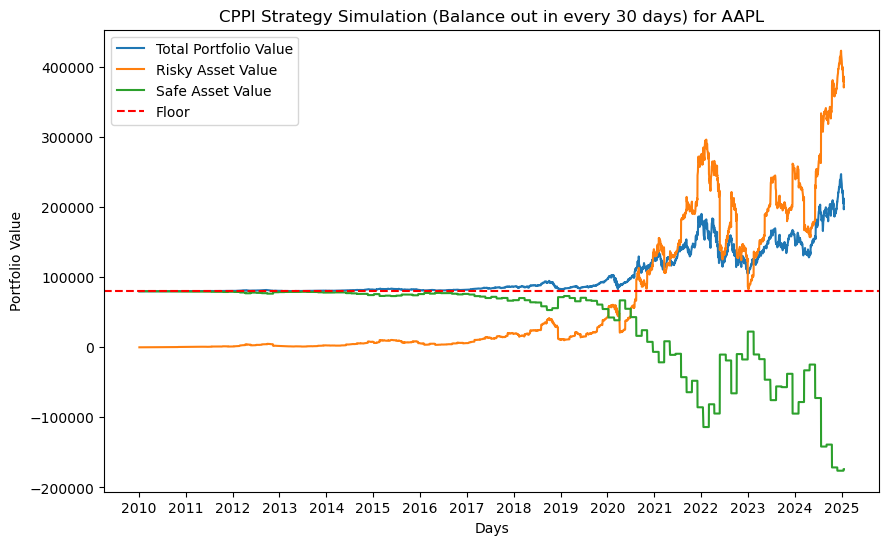

interactive(children=(IntSlider(value=100000, description='initial_wealth', max=300000, min=-100000), IntSlide…

In [11]:
cppi_simulation_plot_controls = widgets.interactive(cppi_simulation_plot,
                                    initial_wealth = 100000,
                                    floor= 80000 ,
                                    multiplier = (1, 5, .5),
                                    start_date = (0, 10000, 365),
                                    risk_free_rate = (0, .15, .01),
                                    balance_in = (0, 252, 1)
)

display(cppi_simulation_plot_controls)

## Conclusion
This project showcases a robust implementation of the CPPI investment strategy using Python. By integrating real-world financial data with interactive simulations, it provides a comprehensive tool for visualizing portfolio performance under varying market conditions and parameters. This practical demonstration highlights expertise in data analysis, visualization, and algorithmic financial modeling.